<a href="https://colab.research.google.com/github/Kussil/Financial_Sentiment_LLM/blob/main/03_Sentiment_Analysis/LLama/Post_Llama_Model_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis for Llama model output

Current notebook contains EDA part and post Llama process cleaning part prior Stock modeling step.

- Notebook uses as input Full_data_Llama_sentiment_analysis_results.csv file: /content/Financial_Sentiment_LLM/03_Sentiment_Analysis/LLama/Full_data_LLama_model_sentiment_analysis_results.csv

- As the output it produces standartized and cleaned csv file for Stock Modeling part:




**NOTE**
GIT HUB API Key is required for uploading and saving into Repository

In [62]:
# Import libraries
from google.colab import userdata
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [63]:
# Connection to GitHub repository
# Import GitHub token with Google secrets and clone the repository
GITHUB_TOKEN = userdata.get('github')
os.environ['GITHUB_TOKEN'] = GITHUB_TOKEN
!git clone  https://{GITHUB_TOKEN}@github.com/Kussil/Financial_Sentiment_LLM.git

fatal: destination path 'Financial_Sentiment_LLM' already exists and is not an empty directory.


In [64]:
# uploading Llama results csv file
path = "/content/Financial_Sentiment_LLM/03_Sentiment_Analysis/LLama/Full_data_LLama_model_sentiment_analysis_results.csv"
llama_output = pd.read_csv(path)

In [65]:
# mapping original column/categories names to generalized version for visualization purposes
column_mapping = {
    'Finance': 'Finance',
    'Production': 'Production',
    'Reserves / Exploration / Acquisitions / Mergers / Divestments': 'Reserves/M&A',
    'Environment / Regulatory / Geopolitics': 'Regulatory',
    'Alternative Energy / Lower Carbon': 'Green Energy',
    'Oil Price / Natural Gas Price / Gasoline Price': 'OG Price'
}

# Rename the columns in the DataFrame
llama_output.rename(columns=column_mapping, inplace=True)

# Update the sentiment_columns list with the new names
sentiment_columns = ['Finance', 'Production', 'Reserves/M&A', 'Regulatory', 'Green Energy', 'OG Price']


In [66]:
def check_sentiment_consistency(value):
    """Verify if a sentiment value is valid.

    Args:
        value (str): The sentiment to check.

    Returns:
        bool: True if valid, False otherwise.

    Valid sentiments: Positive, Neutral, Negative, mixed, Error, N/A, Other.
    """
    valid_sentiments = ['Positive', 'Neutral', 'Negative', 'Mixed', 'Error', 'N/A', 'Other']
    return value in valid_sentiments

# Assume `sentiment_columns` is a predefined list of columns containing sentiment values
# Check inconsistency across all sentiment categories
inconsistent_data = llama_output[sentiment_columns].applymap(lambda x: not check_sentiment_consistency(x))
inconsistent_counts = inconsistent_data.sum()

print("Inconsistent sentiment values:")
print(inconsistent_counts)


Inconsistent sentiment values:
Finance          418
Production       534
Reserves/M&A     586
Regulatory       698
Green Energy    2406
OG Price         721
dtype: int64


***Findings***

Llama model output results show very inconsistent results in terms of sentiment variables different from predefined by the prompt

In [67]:
# Printing out unique sentiment variables per each category for QC
for column in sentiment_columns:
    print(f"\nUnique values in {column}:")
    unique_values = llama_output[column].unique()
    print(unique_values)
    print(f"Total unique values in {column}: {len(unique_values)}")


Unique values in Finance:
['Neutral' 'Positive' 'Negative' '[Neutral]' 'NR' 'N' 'NR-Not Ranked'
 'Error: Max retries reached' '[Positive]' 'N1B' 'NES' 'Mixed' 'N Relic'
 'No JSON found']
Total unique values in Finance: 14

Unique values in Production:
['Positive' 'Neutral' 'Negative'
 'Positive (small increase in U.S. production, likely 300,000 b/d to an estimated 13.2 mmb/d)'
 'Mixed (Positive and Negative)' 'Negative/Positive (Mixed Sentiment)'
 '[Neutral]' 'Slight Negative'
 'Positive (6.0% increase in crude oil production, 7.3% increase in NGL production)'
 'Positive (median increase of 0.4% in crude oil production, 5.1% in NGL production, and 4.8% in natural gas production)'
 'N-Q'
 'Positive (2.1% increase in crude oil production, 7.3% increase in natural gas production)'
 'Positive (6.4% increase expected)'
 'Mixed (Positive for crude oil, Neutral for NGL, Positive for natural gas)'
 'Negative (3.0% decrease in NGL production and 0.7% increase in crude oil production expected)'

**Findings**
- Llama produced differnt variations of the same sentiment, including additional comments supporting the dicision.
- Most of the sentiment options can be generalized using the renaming function using the keywords.

In [68]:
def improved_standardize_sentiment(value):
    """Standardize sentiment values to predefined categories.

    Args:
        value (str): The sentiment value to standardize.

    Returns:
        str: Standardized sentiment value (Positive, Negative, Neutral, Mixed, N/A, Error, Other).
    """
    value = str(value).lower().strip()

    # Positive sentiments
    positive_indicators = [
        'positive', 'increase', 'growth', 'improve', 'higher', 'small increase',
        '2.1% increase', '2% increase', '5.3% increase', '6.0% increase',
        '7.3% increase', 'median increase', 'temporary decrease', 'temporary drop'
    ]

    # Negative sentiments
    negative_indicators = [
        'negative', 'decrease', 'decline', 'lower', 'risk', 'concern', 'no json found',
        'none', 'uncertainty', 'pessimistic', 'concerns over', 'concerned',
        'pulls back', 'lower growth', 'high cost structure', 'failure of exploration efforts',
        'stringent energy regulations', 'moratoriums', 'volatility', 'high prices', 'slowed production'
    ]

    # Neutral sentiments
    neutral_indicators = [
        'neutral', 'unchanged', 'stable', 'mixed', 'n', 'nr', 'nes', 'nmb/d',
        'n.a.', 'nd', 'absent', 'neutral to', 'neutral/negative', 'neutral/positive',
        'neutral (with a mention)', 'n.d.', 'na', 'neutral/neutral'
    ]

    # Mixed sentiments
    mixed_indicators = [
        'mixed', 'positive/negative', 'negative/positive', 'mixed sentiment',
        'partly', 'includes', 'some', 'depending', 'neutral and', 'some neutral',
        'positive trend', 'negative trend', 'both positive and negative', 'positive and negative'
    ]

    # Not Applicable categories
    not_applicable_indicators = [
        'n/a', 'not applicable', 'not mentioned', 'no mention',
        'none mentioned', 'nq', 'absent', 'no sentiment', 'not rated', 'not relevant',
        'no specific information provided', 'no direct mention', 'no information provided',
        'not applicable to', 'no data provided', 'unknown', 'not significant'
    ]

    # Error categories
    error_indicators = [
        'error', 'error: max retries reached', 'no JSON found'
    ]

    # Determine the standardized sentiment category based on the value
    if any(word in value for word in positive_indicators):
        return 'Positive'
    elif any(word in value for word in negative_indicators):
        return 'Negative'
    elif any(word in value for word in neutral_indicators):
        return 'Neutral'
    elif any(word in value for word in mixed_indicators):
        return 'Mixed'
    elif any(word in value for word in not_applicable_indicators):
        return 'N/A'
    elif any(word in value for word in error_indicators):
        return 'Error'
    else:
        return 'Other'


In [69]:
# Apply the improved standardization to each sentiment column
sentiment_columns = ['Finance', 'Production', 'Reserves/M&A', 'Regulatory', 'Green Energy', 'OG Price']
standartized_llama_output = llama_output.copy()
for column in sentiment_columns:
    standartized_llama_output[column] = standartized_llama_output[column].apply(improved_standardize_sentiment)

# Print standardized value counts for each category
for column in sentiment_columns:
    print(f"\nStandardized value counts for {column}:")
    print(standartized_llama_output[column].value_counts())


Standardized value counts for Finance:
Finance
Neutral     6768
Positive    2077
Negative    1227
Error         53
Name: count, dtype: int64

Standardized value counts for Production:
Production
Neutral     5045
Positive    3079
Negative    1948
Error         53
Name: count, dtype: int64

Standardized value counts for Reserves/M&A:
Reserves/M&A
Neutral     6608
Positive    2080
Negative    1382
Error         53
Other          2
Name: count, dtype: int64

Standardized value counts for Regulatory:
Regulatory
Neutral     5909
Negative    3300
Positive     862
Error         53
Other          1
Name: count, dtype: int64

Standardized value counts for Green Energy:
Green Energy
Neutral     7985
Positive    1410
Negative     675
Error         53
Other          2
Name: count, dtype: int64

Standardized value counts for OG Price:
OG Price
Neutral     5510
Negative    2636
Positive    1924
Error         53
Other          2
Name: count, dtype: int64


***Findings***
All six categories were succussfully standartized
- Data indicates Neutral bias across all categories
- Error exists only for 53 cases
- Other for 2

In [70]:
def plot_horizontal_grouped_sentiment_by_source(data, sentiment_columns):
    # Prepare the data
    sentiment_counts = {}
    sources = data['Source'].unique()

    for column in sentiment_columns:
        sentiment_counts[column] = data.groupby('Source')[column].value_counts(normalize=True).unstack()

    # Set up the plot
    fig, ax = plt.subplots(figsize=(15, 3 * len(sources)))

    # Define simplified color scheme
    color_map = {
        'Positive': '#00A86B',  # Green
        'Neutral': '#87CEEB',   # Blue
        'Negative': '#FF4136',  # Red
        'Error': '#000000'      # Black
    }

    # Convert color_map keys to a list for indexing
    sentiment_order = list(color_map.keys())

    # Set the height of each bar and the positions of the bars
    bar_height = 0.15
    r = np.arange(len(sources))

    # Plot bars for each sentiment category
    for i, column in enumerate(sentiment_columns):
        # Ensure all sentiment categories are present, fill with 0 if missing
        for sentiment in sentiment_order:
            if sentiment not in sentiment_counts[column].columns:
                sentiment_counts[column][sentiment] = 0

        # Plot bars
        for sentiment in sentiment_order:
            left = sentiment_counts[column][[s for s in sentiment_order if sentiment_order.index(s) < sentiment_order.index(sentiment)]].sum(axis=1)
            ax.barh(r + i*bar_height, sentiment_counts[column][sentiment], left=left, color=color_map[sentiment], height=bar_height)

        # Add text labels
        ax.text(1.02, r[len(r)//2] + i*bar_height, f'{column}', va='center', ha='left', fontsize=10)

    # Customize the plot
    ax.set_ylabel('Source', fontweight='bold')
    ax.set_xlabel('Proportion', fontweight='bold')
    ax.set_title('Sentiment Distribution by Source and Category', fontweight='bold')
    ax.set_yticks(r + bar_height * (len(sentiment_columns) - 1) / 2)
    ax.set_yticklabels(sources)

    # Add simplified legend
    handles = [plt.Rectangle((0,0),1,1, color=color) for color in color_map.values()]
    ax.legend(handles, color_map.keys(), title="Sentiment", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add grid lines
    ax.set_axisbelow(True)
    ax.xaxis.grid(color='gray', linestyle='dashed', alpha=0.7)

    plt.tight_layout()
    plt.show()


In [71]:
def plot_horizontal_grouped_sentiment_by_source(data, sentiment_columns):
    """Plot horizontal grouped bar charts of sentiment distribution by source and category.

    Args:
        data (DataFrame): The input DataFrame containing sentiment data.
        sentiment_columns (list): List of column names containing sentiment values.

    Returns:
        None: Displays a horizontal grouped bar chart.
    """
    # Prepare the data
    sentiment_counts = {}
    sources = data['Source'].unique()

    for column in sentiment_columns:
        sentiment_counts[column] = data.groupby('Source')[column].value_counts(normalize=True).unstack()

    # Set up the plot
    fig, ax = plt.subplots(figsize=(15, 3 * len(sources)))

    # Define simplified color scheme
    color_map = {
        'Positive': '#00A86B',  # Green
        'Neutral': '#87CEEB',   # Blue
        'Negative': '#FF4136',  # Red
        'Error': '#000000'      # Black
    }

    # Convert color_map keys to a list for indexing
    sentiment_order = list(color_map.keys())

    # Set the height of each bar and the positions of the bars
    bar_height = 0.15
    r = np.arange(len(sources))

    # Plot bars for each sentiment category
    for i, column in enumerate(sentiment_columns):
        # Ensure all sentiment categories are present, fill with 0 if missing
        for sentiment in sentiment_order:
            if sentiment not in sentiment_counts[column].columns:
                sentiment_counts[column][sentiment] = 0

        # Plot bars
        for sentiment in sentiment_order:
            left = sentiment_counts[column][[s for s in sentiment_order if sentiment_order.index(s) < sentiment_order.index(sentiment)]].sum(axis=1)
            ax.barh(r + i*bar_height, sentiment_counts[column][sentiment], left=left, color=color_map[sentiment], height=bar_height)

        # Add text labels
        ax.text(1.02, r[len(r)//2] + i*bar_height, f'{column}', va='center', ha='left', fontsize=10)

    # Customize the plot
    ax.set_ylabel('Source', fontweight='bold')
    ax.set_xlabel('Proportion', fontweight='bold')
    ax.set_title('Sentiment Distribution by Source and Category', fontweight='bold')
    ax.set_yticks(r + bar_height * (len(sentiment_columns) - 1) / 2)
    ax.set_yticklabels(sources)

    # Add simplified legend
    handles = [plt.Rectangle((0,0),1,1, color=color) for color in color_map.values()]
    ax.legend(handles, color_map.keys(), title="Sentiment", bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add grid lines
    ax.set_axisbelow(True)
    ax.xaxis.grid(color='gray', linestyle='dashed', alpha=0.7)

    plt.tight_layout()
    plt.show()


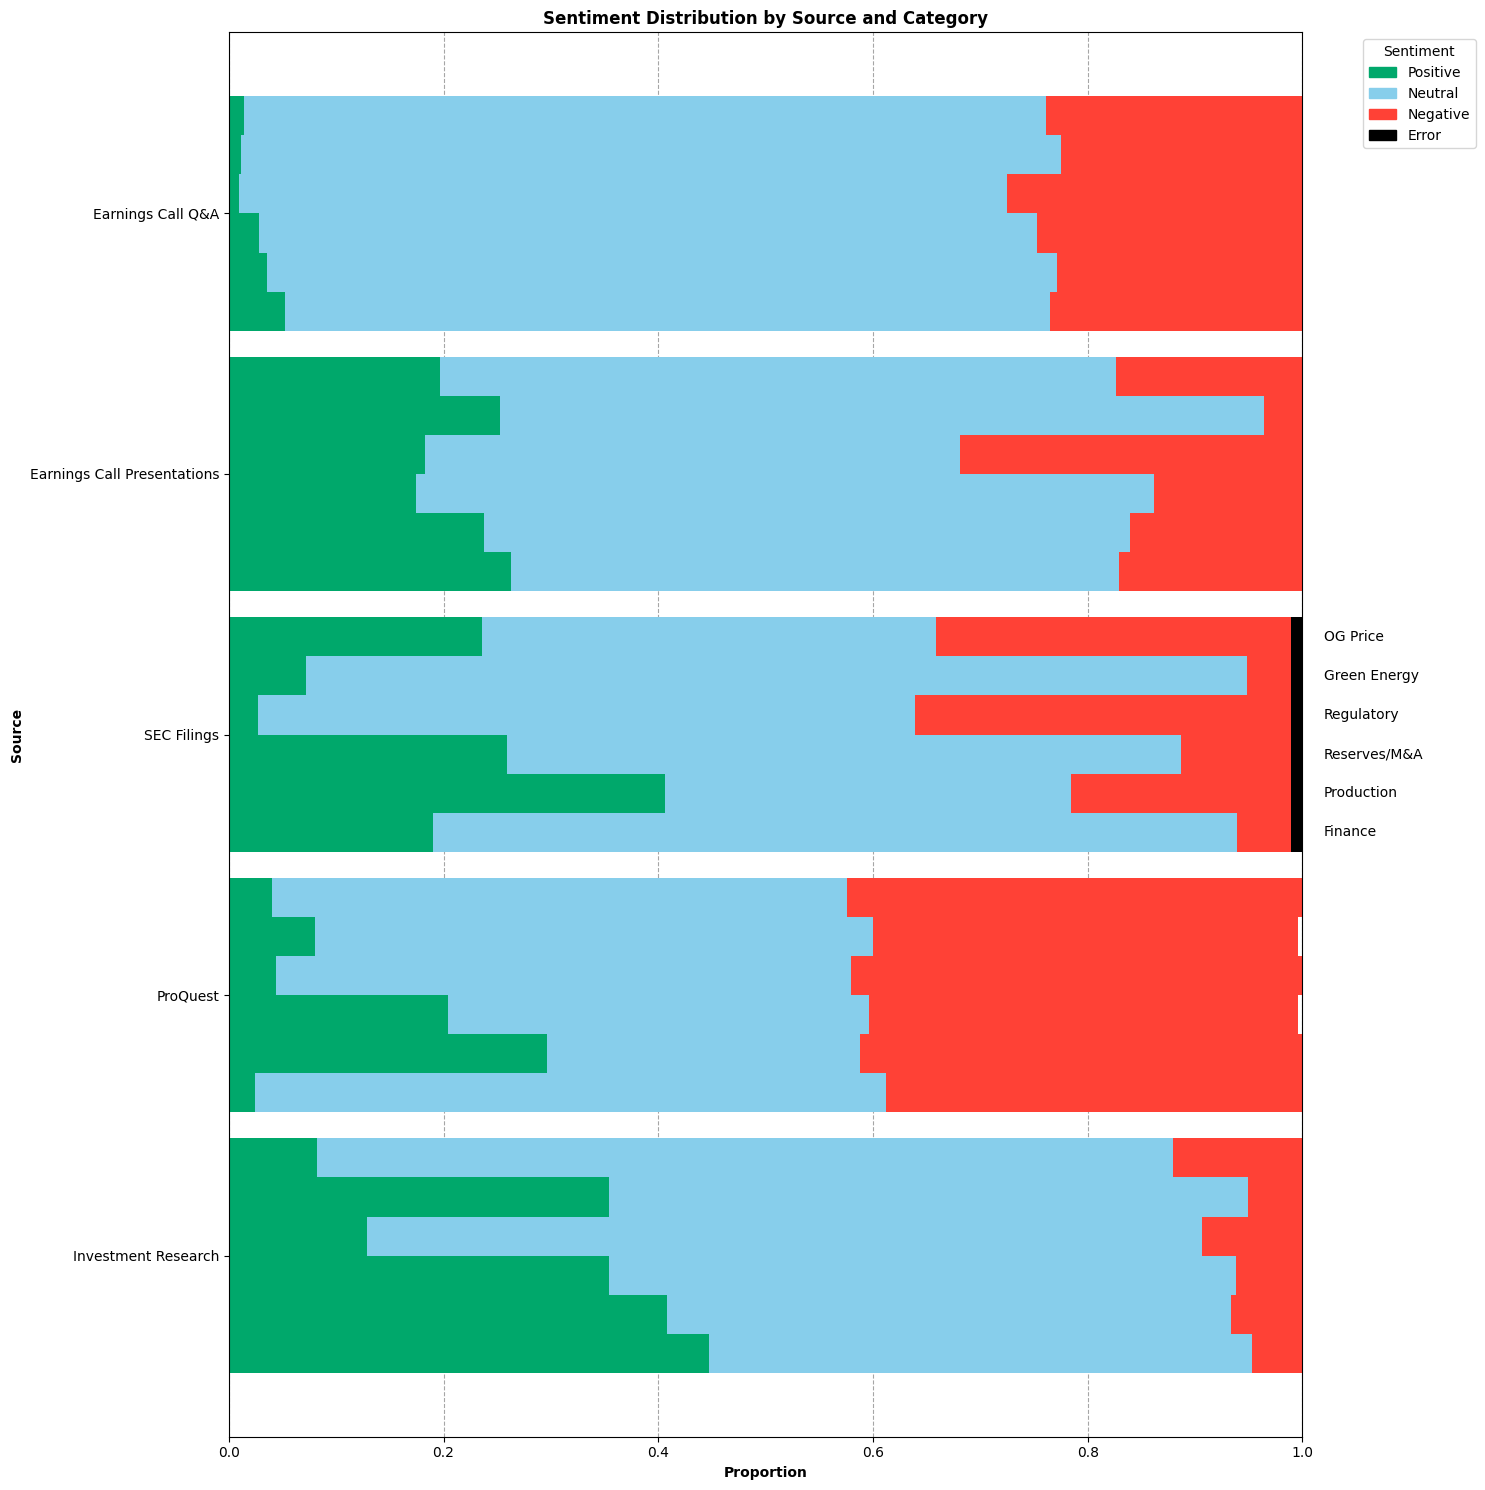

In [72]:

# Use the function
plot_horizontal_grouped_sentiment_by_source(standartized_llama_output, sentiment_columns)

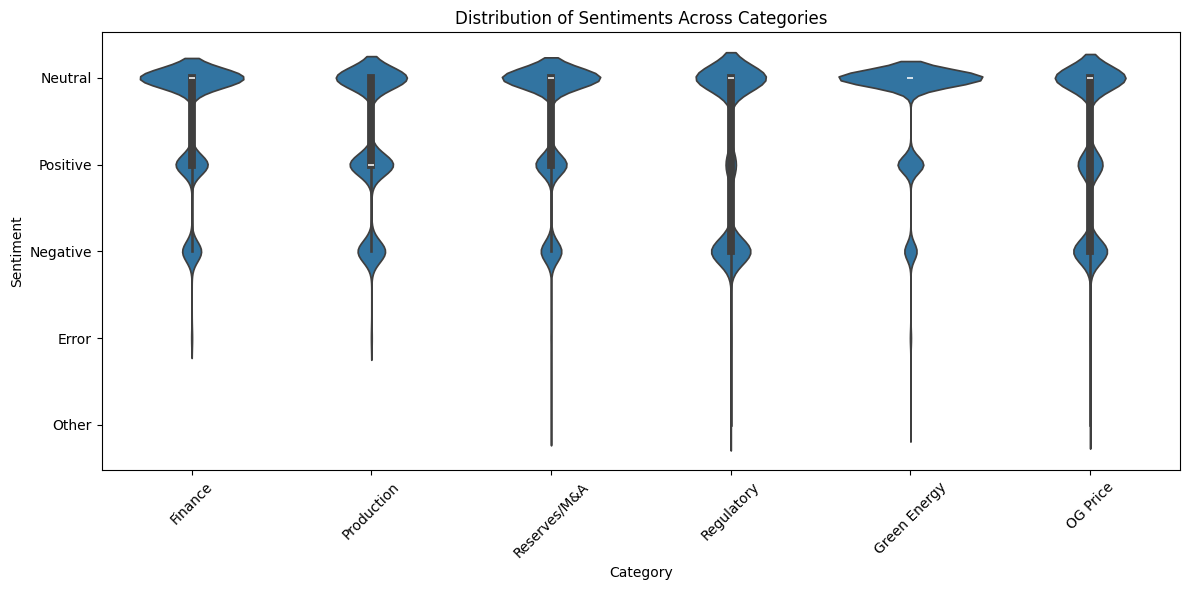

In [73]:


def plot_violin(data, sentiment_columns):
    # Prepare data for violin plot
    violin_data = data.melt(value_vars=sentiment_columns, var_name='Category', value_name='Sentiment')

    plt.figure(figsize=(12, 6))
    sns.violinplot(x='Category', y='Sentiment', data=violin_data)
    plt.title('Distribution of Sentiments Across Categories')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_violin(standartized_llama_output, sentiment_columns)

In [74]:


def plot_parallel_categories(data, sentiment_columns):
    # Define color scheme
    color_map = {
        'Positive': '#00A86B',  # Green
        'Neutral': '#87CEEB',   # Blue
        'Negative': '#FF4136',  # Red
        'Error': '#000000'      # Black
    }

    # Prepare dimensions
    dimensions = [
        {'label': 'Source', 'values': data['Source']}
    ]
    for col in sentiment_columns:
        dimensions.append({'label': col, 'values': data[col]})

    # Prepare color data
    color_data = []
    for col in sentiment_columns:
        color_data.extend([color_map.get(val, '#CCCCCC') for val in data[col]])

    # Create the parallel categories diagram
    fig = go.Figure(data=[go.Parcats(
        dimensions=dimensions,
        line={'color': color_data, 'shape': 'hspline'},
        hoveron='color',
        hoverinfo='count+probability',
        labelfont={'size': 14, 'family': 'Arial'},
        tickfont={'size': 12, 'family': 'Arial'},
        arrangement='freeform',
    )])

    fig.update_layout(
        title='Parallel Categories of Sentiments Across Sources',
        height=500,  # Increase height for better visibility
        margin=dict(l=100, r=100, t=100, b=100)  # Adjust margins
    )

    fig.show()

plot_parallel_categories(standartized_llama_output, sentiment_columns)

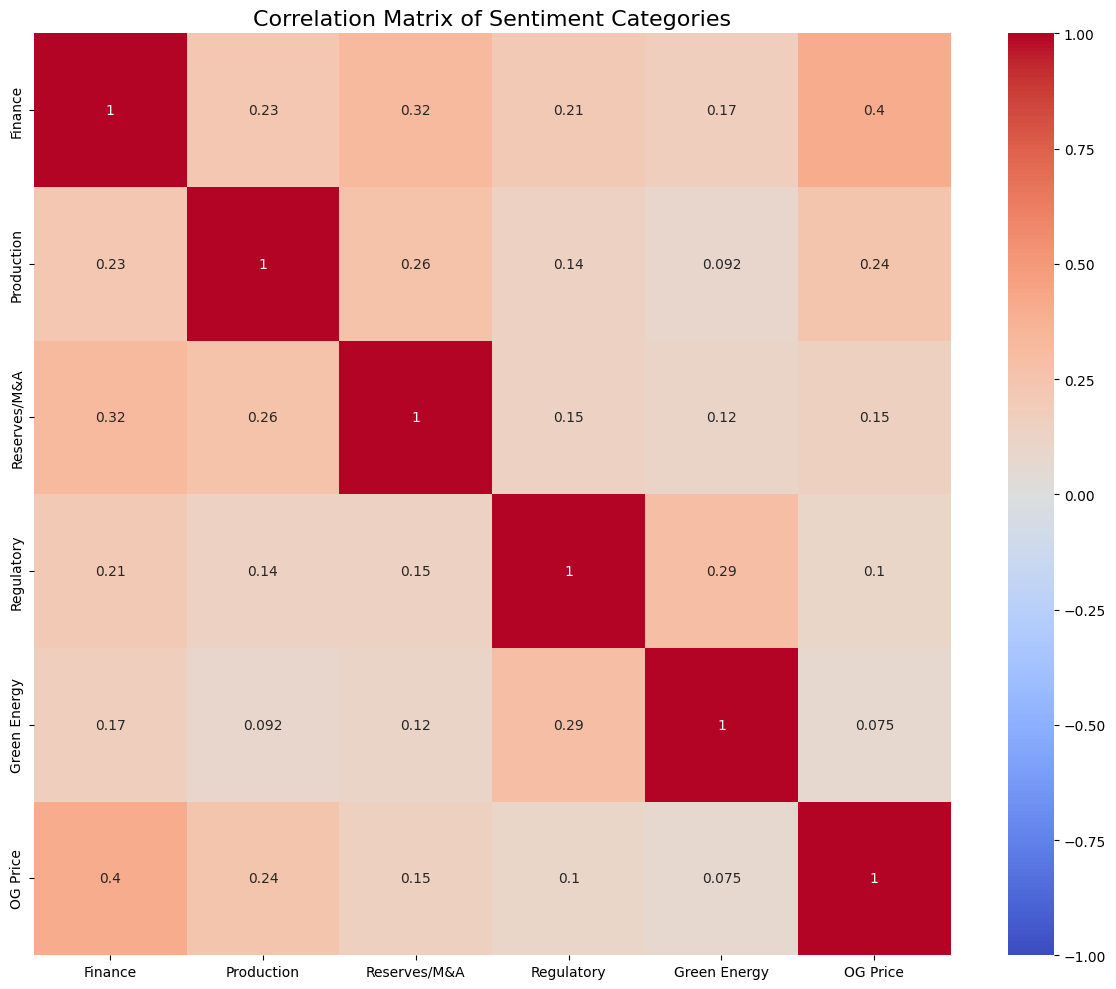

               Finance  Production  Reserves/M&A  Regulatory  Green Energy  \
Finance       1.000000    0.230557      0.320042    0.211246      0.166235   
Production    0.230557    1.000000      0.258350    0.137826      0.092379   
Reserves/M&A  0.320042    0.258350      1.000000    0.146919      0.115841   
Regulatory    0.211246    0.137826      0.146919    1.000000      0.290308   
Green Energy  0.166235    0.092379      0.115841    0.290308      1.000000   
OG Price      0.401327    0.243829      0.150976    0.103035      0.074655   

              OG Price  
Finance       0.401327  
Production    0.243829  
Reserves/M&A  0.150976  
Regulatory    0.103035  
Green Energy  0.074655  
OG Price      1.000000  


In [75]:

def create_correlation_matrix(data, sentiment_columns):
    # Step 1: Encode sentiment categories numerically
    sentiment_map = {'Negative': -1, 'Neutral': 0, 'Positive': 1, 'Error': np.nan, 'Other': np.nan}

    encoded_data = data[sentiment_columns].replace(sentiment_map)

    # Step 2: Calculate the correlation matrix
    corr_matrix = encoded_data.corr()

    # Step 3: Create a heatmap of the correlation matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Correlation Matrix of Sentiment Categories', fontsize=16)
    plt.tight_layout()
    plt.show()

    return corr_matrix

# Use the function
correlation_matrix = create_correlation_matrix(standartized_llama_output, sentiment_columns)
print(correlation_matrix)

# **Pushing Cleaned and Standartized LLama model output into Repository**

In [86]:
# Cleaning from dublicated columns
standartized_llama_output.drop('Reserves / Exploration / Acquisitions / Mergers / Divestitures', axis=1, inplace=True)

# Define the path where you want to save the CSV file
output_path = '/content/Financial_Sentiment_LLM/03_Sentiment_Analysis/LLama/Llama_data_for_stock_modeling.csv'

# Save the DataFrame
standartized_llama_output.to_csv(output_path, index=False)
print(f"Data successfully saved to '{output_path}'.")

# Add the new CSV file to the staging area
!git add 03_Sentiment_Analysis/LLama/Llama_data_for_stock_modeling.csv
!git config --global user.email "ik25@rice.edu"
!git config --global user.name "Kussil"
!git commit -m "Add Llama_data_for_stock_modeling.csv"
# Push the changes to the repository
!git push

[main 9ecb636] Add Llama_data_for_stock_modeling.csv
 1 file changed, 10126 insertions(+)
 create mode 100644 03_Sentiment_Analysis/LLama/Llama_data_for_stock_modeling.csv
Enumerating objects: 8, done.
Counting objects: 100% (8/8), done.
Delta compression using up to 12 threads
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 179.45 KiB | 4.60 MiB/s, done.
Total 5 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/Kussil/Financial_Sentiment_LLM.git
   3670eaa..9ecb636  main -> main
